# SoundCoop Paper - Figure for Case Study 1 AU_CH01 Sep Plots

This Jupyter Notebook applies the analysis and creates the subsequent plot for the Case Study 1 figure in the Wall et al A Collaborative Framework to Address Big Data Challenges in Marine Passive Acoustic Monitoring paper detailing the SoundCoop project. This case study examines changing sound levels relative to a reference period.

The code pulls one-minute hybrid millidecade (HMD) spectra calculated for the NOAA Alaska Fisheries Science Center AU_CH01 datasets that are hosted on the NOAA Open Data Dissemination Program Google Cloud Platform bucket associated with the NOAA National Centers for Environmental Information Passive Acoustic Data Archive. The HMD spectra were median aggregated to one-day resolution, and processed into a median power spectral density (PSD) for each available year’s September. A 5-kernel window size, one dimensional median filter was applied to the median PSD to remove impulsive artifacts. Years with “Good” quality minutes less than 80% of the expected total were omitted from the analysis. This threshold was applied to 2008, 2010-2015, and 2021. The September 2009 median PSD was subtracted from subsequent year’s September median PSD, and plotted to illustrate relative change across years. The frequency range is truncated to 100 to 1,000 Hz.

NOAA Alaska Fisheries Science Center Marine Mammal Laboratory (2023). Hybrid Millidecade Spectra at 1 Minute Resolution Recorded by the Alaska Fisheries Science Center (AFSC). NOAA National Centers for Environmental Information. (https://doi.org/10.25921/sw1h-g843).

contact: carrie.wall@noaa.gov

## Setup

To start, we need to install the required dependencies. This notebook has been tested in Python 3.11. You only need to run this once per environment

In [18]:
import sys
sys.path = ['.'] + sys.path
!pip install pvlib
!pip install lifewatch-pypam==0.3.2
!pip install minio

## Import packages

We'll start importing all the packages we will need

In [19]:
import pathlib
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
import re
import seaborn as sns
from scipy.signal import medfilt
from datetime import datetime

In [20]:
from pypam.acoustic_survey import ASA
import pypam.utils
import pypam.plots

## Download the data

In [21]:
from minio import Minio
from minio.error import S3Error

from pathlib import Path
import os.path

Here we define where the data are stored to be able to access it

In [22]:
CLIENT = Minio('storage.googleapis.com')
BUCKET = 'noaa-passive-bioacoustic'
station = 'AU_CH01'
PREFIX = 'soundcoop'
name_format = '%Y%m%d'

Here we define the local paths where we will download the data and the output from this notebook

In [23]:
# Make the main storage folder
local_path = '../../shared/data' # change to your local path
output_path = local_path + '/figures'

if not os.path.isdir(local_path):
    Path(local_path).mkdir()

if not os.path.isdir(output_path):
    Path(output_path).mkdir()

station_path = Path(local_path).joinpath(station)
if not os.path.isdir(station_path):
    Path(station_path).mkdir()

Here we define a function to download data from a station

In [24]:
def download_data_station(station_name, 
                          client_obj, 
                          bucket_str, 
                          prefix_str, 
                          data_path,
                          name_format,
                          month):
    station_folder = pathlib.Path(data_path).joinpath(station_name)
    if not station_folder.exists():
        os.mkdir(station_folder)
    objects = list(client_obj.list_objects(bucket_str, prefix=prefix_str))
    ct = 0
    for i, obj in enumerate(objects):
        object_name = obj.object_name
        path_name = pathlib.Path(object_name).name
        if (not path_name.startswith('.')) & path_name.endswith('.nc'):
            match = re.findall(r"_(\d+)", path_name)[-1]
            file_date = datetime.strptime(match, name_format)
            # Here we filter by month, as all the data we download is ONLY from the September month
            if (file_date.month == month):
                download_path = data_path + '/' + station_name + '/' + pathlib.Path(object_name).name
                if os.path.isfile(download_path):
                    print('Already downloaded: ' + download_path)
                else:
                    print('Download ' + str(ct) + ' of ' + str(len(objects)) + ': ' + download_path)
                    object_data = client_obj.get_object(bucket_str, object_name)
                    if not os.path.isdir(download_path):
                        with open(str(download_path), 'wb') as file_data:
                            for data in object_data:
                                file_data.write(data)
                    file_data.close()
            else: 
                print('Ignored, out of selected period or not a netCDF file ' + path_name)
        ct += 1

And then we download the data only for the month of September (to save some space)

In [8]:
download_data_station(station, CLIENT, BUCKET, f'{PREFIX}/{station}/', local_path, name_format=name_format, month=9)

Ignored, out of selected period or not a netCDF file AU_CH01_200706211FAF.1.8192_20111015_DAILY_MILLIDEC_MinRes.nc
Ignored, out of selected period or not a netCDF file AU_CH01_200706211FAF.1.8192_20111016_DAILY_MILLIDEC_MinRes.nc
Ignored, out of selected period or not a netCDF file AU_CH01_200706211FAF.1.8192_20111017_DAILY_MILLIDEC_MinRes.nc
Ignored, out of selected period or not a netCDF file AU_CH01_200706211FAF.1.8192_20111018_DAILY_MILLIDEC_MinRes.nc
Ignored, out of selected period or not a netCDF file AU_CH01_200706211FAF.1.8192_20111019_DAILY_MILLIDEC_MinRes.nc
Ignored, out of selected period or not a netCDF file AU_CH01_200706211FAF.1.8192_20111020_DAILY_MILLIDEC_MinRes.nc
Ignored, out of selected period or not a netCDF file AU_CH01_200706211FAF.1.8192_20111021_DAILY_MILLIDEC_MinRes.nc
Ignored, out of selected period or not a netCDF file AU_CH01_200706211FAF.1.8192_20111022_DAILY_MILLIDEC_MinRes.nc
Ignored, out of selected period or not a netCDF file AU_CH01_200706211FAF.1.8192

## Get data by year & resample the temporal resolution

We will downsample the one minute to daily resolution since it is time and memory intesive to work with the full resolution data and we are most interested in the general trends.

In [25]:
RESAMPLE_RESOLUTION = '1D'
min_freq = 20
max_freq = 4096

In [26]:
def load_data_from_station_year(station, filter_by):
    deployment_path = pathlib.Path(local_path).joinpath(station)
    print(f'loading station {station} containing {filter_by}...')
    aggregated_ds = pypam.utils.join_all_ds_output_deployment(
        deployment_path, data_vars=['psd','quality_flag'], datetime_coord='time',
        join_only_if_contains=f'_{filter_by}', load=True,
        parallel=False, freq_band=[min_freq, max_freq],
        freq_coord='frequency'
    )
  
    if 'quality_flag' in aggregated_ds.data_vars:
        aggregated_ds['psd'] = aggregated_ds.psd.where(aggregated_ds.quality_flag.isin([1]))

    aggregated_ds = aggregated_ds.drop_vars('quality_flag')
    cleaned_data = aggregated_ds['psd'].dropna(dim='time')

    aggregated_ds = aggregated_ds.resample(time=RESAMPLE_RESOLUTION).median()
    return aggregated_ds

We'll load all the data we have downloaded per year, and store each year. Because we're only interested in the month of September, we set the filter_by parameter to the year-month string. This way, even if we downloaded more data than the one of September, we will only load the September data. 

In [27]:
station = 'AU_CH01'

#ds_collection_2008 = load_data_from_station_year(station, 2008) #not loaded due to insufficient data coverage
ds_collection_2009 = load_data_from_station_year(station, filter_by='200909')
#ds_collection_2010 = load_data_from_station_year(station, 2010) #not loaded due to insufficient data coverage
#ds_collection_2011 = load_data_from_station_year(station, 2011) #not loaded due to insufficient data coverage
#ds_collection_2012 = load_data_from_station_year(station, 2012) #not loaded due to insufficient data coverage
#ds_collection_2013 = load_data_from_station_year(station, 2013) #not loaded due to insufficient data coverage
ds_collection_2014 = load_data_from_station_year(station, filter_by='201409')
#ds_collection_2015 = load_data_from_station_year(station, 2015) #not loaded due to insufficient data coverage
ds_collection_2016 = load_data_from_station_year(station, filter_by='201609')
ds_collection_2017 = load_data_from_station_year(station, filter_by='201709')
ds_collection_2018 = load_data_from_station_year(station, filter_by='201809')
ds_collection_2019 = load_data_from_station_year(station, filter_by='201909')
ds_collection_2020 = load_data_from_station_year(station, filter_by='202009')
ds_collection_2021 = load_data_from_station_year(station, filter_by='202109')
ds_collection_2022 = load_data_from_station_year(station, filter_by='202209')

loading station AU_CH01 containing 200909...
[########################################] | 100% Completed | 104.49 ms
loading station AU_CH01 containing 201409...
[########################################] | 100% Completed | 102.07 ms
loading station AU_CH01 containing 201609...
[########################################] | 100% Completed | 103.56 ms
loading station AU_CH01 containing 201709...
[########################################] | 100% Completed | 102.11 ms
loading station AU_CH01 containing 201809...
[########################################] | 100% Completed | 104.03 ms
loading station AU_CH01 containing 201909...
[########################################] | 100% Completed | 104.98 ms
loading station AU_CH01 containing 202009...
[########################################] | 100% Completed | 104.41 ms
loading station AU_CH01 containing 202109...
[########################################] | 100% Completed | 102.49 ms
loading station AU_CH01 containing 202209...
[##################

In [28]:
sns.set_theme(style='ticks')

### Relative change from year 1

View change in PSD across years using earliest full year as the baseline

In [29]:
def change_from_year1(base_year, other_year) :
    base_psd = base_year['psd'].median(dim='time').values
    base = medfilt(base_psd, kernel_size=5)
    other_psd = other_year['psd'].median(dim='time').values
    other = medfilt(other_psd, kernel_size=5)
    diff = other - base
    data_array = xr.DataArray(diff, coords={'frequency': base_year.frequency}, dims='frequency', name='diff')
    diff_array = xr.Dataset()
    diff_array['diff'] = data_array

    return diff_array

Here we apply the above function to calculate each year's difference from 2009

In [30]:
diff2016 = change_from_year1(ds_collection_2009,ds_collection_2016)
diff2017 = change_from_year1(ds_collection_2009,ds_collection_2017)
diff2018 = change_from_year1(ds_collection_2009,ds_collection_2018)
diff2019 = change_from_year1(ds_collection_2009,ds_collection_2019)
diff2020 = change_from_year1(ds_collection_2009,ds_collection_2020)
diff2022 = change_from_year1(ds_collection_2009,ds_collection_2022)

Here we plot and save the results, limiting the frequency range to 100 to 1,000 Hz

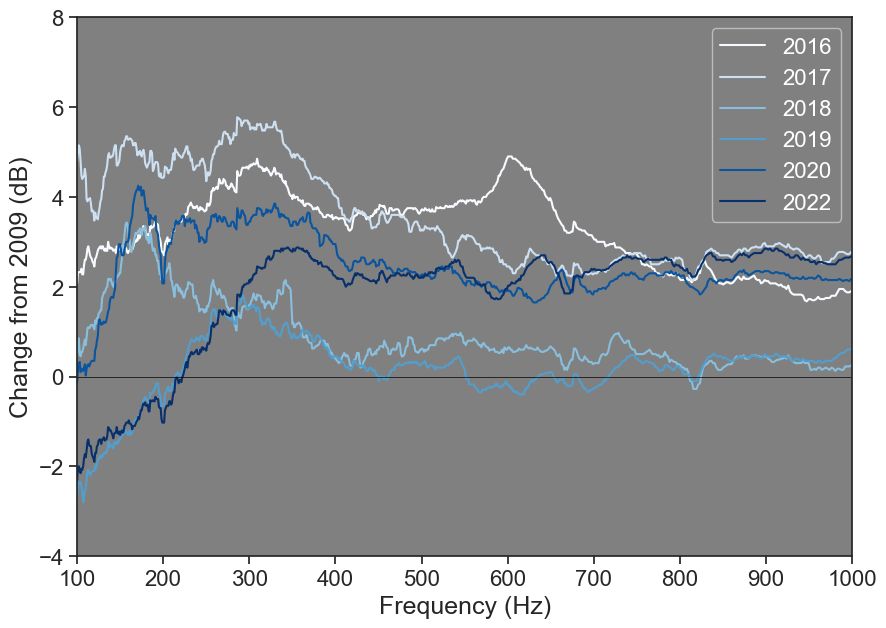

In [33]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"
})

# Create a sequential colormap
colormap = cm.Blues  # You can use any sequential colormap available in matplotlib

# Create a list of colors from the colormap
colors = colormap(np.linspace(0, 1, 15))

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(diff2016['frequency'].values, diff2016['diff'], label='2016',color=colors[0])
ax.plot(diff2017['frequency'].values, diff2017['diff'], label='2017',color=colors[3])
ax.plot(diff2018['frequency'].values, diff2018['diff'], label='2018',color=colors[6])
ax.plot(diff2019['frequency'].values, diff2019['diff'], label='2019',color=colors[8])
ax.plot(diff2020['frequency'].values, diff2020['diff'], label='2020',color=colors[12])
ax.plot(diff2022['frequency'].values, diff2022['diff'], label='2022',color=colors[14])

ax.axhline(0,color='black',linestyle='-',linewidth=0.5)

# Set face color to grey
ax.set_facecolor('grey')

ax.set_xlim(100, 1000)
ax.set_ylim(-4.0, 8)

# Add labels and title
ax.set_xlabel('Frequency (Hz)', fontsize=18)
ax.set_ylabel('Change from 2009 (dB)', fontsize=18) 
legend = ax.legend(facecolor='grey', fontsize=16)
plt.setp(legend.get_texts(), color='white')  # Set font color to white

# Set the font size of x-tick labels
ax.tick_params(axis='x', labelsize=16)

# Set the font size of y-tick labels (optional)
ax.tick_params(axis='y', labelsize=16)

# Show the plot
plt.show()

# Save the plot
fig.savefig(output_path + '/SoundCoopPaper-CaseStudy1.png') # save as png